## Exakte Berechnung von Erwartungswerten
$$s:=\sum_{i=1}^m p_i \cdot \mathbb{1}(p_i \ge 1)$$

$$E(V)=
  \begin{cases}
      0 & ,\;V=(0,\ldots,0) \\
      \displaystyle\frac{1}{s}+ \displaystyle\sum_{i=1}^m \frac{p_i}{s} \cdot \mathbb{1}(p_i\ge 1)\cdot E(V_i) & \text{, sonst}
   \end{cases}$$
Mit $V_i$ wird diejenige Strategie beschrieben, die sich ergibt, wenn im nächsten Zug ein Chip vom $i$-ten Feld entfernt wird. Falls das Feld leer ist, entfällt der Term.

In dem folgenden Programm gilt $$d_i=p_i \cdot  \mathbb{1}(p_i\ge 1).$$
Eingaben:
- Zeile 4: Wahrscheinlichkeiten für die einzelnen Felder 
- Zeile 5: Setzstrategie, mit der das Spiel startet

Bemerkung: Die Zeilennummern verändern sich (natürlich) bei weiteren Eingaben.

In [1]:
from fractions import Fraction

# Eingabe
p=[1/2,1/3,1/6] # Wahrscheinlichkeiten (Bsp.: Würfel trifft)
S=[4,2,0]       # Setzstrategie (Verteilung der Chips)
#

def E(C, memo={}):
    if tuple(C) in memo: return memo[tuple(C)]

    if all(x == 0 for x in C): return Fraction(0)
   
    # d_i berechnen
    d = [Fraction(0)] * n
    for i in range(n):
        if C[i] > 0: d[i] = p[i]

    # Summe s
    s = sum(d)

    # Rekursive Berechnung des Erwartungswertes
    EX = Fraction(1, s)
    for i in range(n):
        if C[i] > 0:
            C_new = C.copy() 
            C_new[i] -= 1
            EX += (d[i] / s) * E(C_new, memo)

    # Memoization store
    memo[tuple(C)] = EX
    return EX

n=len(S)
p =[Fraction(x).limit_denominator() for x in p] # Umwandlung als Bruch  
EX = E(S) # Berechnung des Erwartungswertes
print(f"Erwartungswert (gerundet): E({S}) = {float(EX):.5}")
print(f"Erwartungswert (exakt)   : E({S}) =  {EX}")

Erwartungswert (gerundet): E([4, 2, 0]) = 9.3997
Erwartungswert (exakt)   : E([4, 2, 0]) =  29374/3125


## Vergleich der Erwartungswerte aller möglichen Strategien
Mit diesem Programm werden die Erwartungswerte aller möglichen Strategien 
- berechnet,
- der Größe nach sortiert,
- grafisch dargestellt,
- in eine ECXEL-Datei gespeichert.

Hierfür müssen im Abschnitt **Eingabe** die folgenden Werte eingegeben werden:
- Wahrscheinlichkeiten für die einzelnen Felder $p=(p_1,\ldots,p_m)$
- Anzahl der Felder: fields
- Anzahl der Chips: chips

Der Name der EXCEL-Datei kann in der Zeile *excel_file = 'expected_values.xlsx'* geändert werdem (s. Abschnitt **Ausgabe*).

Beispiel einer grafischen Ausgabe für ***Würfel trifft*** mit $p=(\frac{1}{2},\frac{1}{3},\frac{1}{6})$.
![Darstellung aller Erwartungswerte, sortiert nach Groesse](Grafik-EX-gesamt.jpg)

Anzahl der generierten Strategien: 28
Ergebnisse wurden in 'expected_values.xlsx' gespeichert.
Die ersten 5 Einträge:
    Strategy  Expected Value
0  [2, 2, 2]        9.638889
1  [3, 2, 1]       10.548611
2  [3, 1, 2]       10.548611
3  [2, 3, 1]       10.548611
4  [2, 1, 3]       10.548611


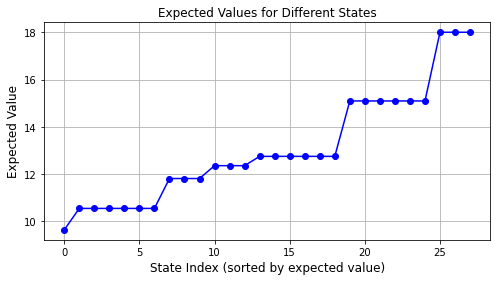

In [2]:
import numpy as np
import pandas as pd
from itertools import combinations_with_replacement
import openpyxl
import matplotlib.pyplot as plt

# Eingaben
p = [1/3, 1/3, 1/3] # Wahrscheinlichlkeiten für die einzelnen Felder
fields=3
chips=6

# Memoization dictionary für bereits berechnete Zustände
memo = {}

# Rekursive Funktion für den Erwartungswert mit beliebigen m Feldern
def expected_value(chips, probs):
    # Basisfall: Wenn keine Chips mehr übrig sind, ist der erwartete Wert 0
    if all(c == 0 for c in chips):
        return 0
    
    # Umwandeln der chips-Liste in ein Tupel, um es als Schlüssel im Memo zu verwenden
    chips_tuple = tuple(chips)
    
    # Wenn der Zustand bereits berechnet wurde, aus dem Cache holen
    if chips_tuple in memo:
        return memo[chips_tuple]
    
    # Berechnung des Erwartungswerts für den aktuellen Zustand
    weighted_sum = 0  # Gewichtete Summe der rekursiven Aufrufe
    total_weight = 0  # Summe der Wahrscheinlichkeiten der möglichen Züge
    
    # Durch alle Felder iterieren
    for i in range(len(chips)):
        if chips[i] > 0:  # Nur Felder mit Chips berücksichtigen
            # Verringere die Anzahl der Chips auf dem aktuellen Feld um 1
            new_chips = chips[:]
            new_chips[i] -= 1
            # Rekursiver Aufruf
            weighted_sum += probs[i] * expected_value(new_chips, probs)
            total_weight += probs[i]
    
    # Normiere sowohl die 1 als auch die gewichtete Summe durch total_weight
    if total_weight > 0:
        result = (1 / total_weight) + (weighted_sum / total_weight)
    else:
        result = 0  # Sicherheitscheck, sollte aber nie passieren
    
    # Speichern des Ergebnisses in der Memoization-Tabelle
    memo[chips_tuple] = result
    return result

# Generiere alle möglichen Strategien 18 Chips auf 6 Feldern
def generate_states(total_chips, num_fields):
    """
    Erzeugt alle möglichen Verteilungen von 'total_chips' auf 'num_fields' Felder.
    """
    for c in combinations_with_replacement(range(num_fields), total_chips):
        strategy = [0] * num_fields
        for i in c:
            strategy[i] += 1
        yield strategy

# Berechne Erwartungswerte für alle Zustände und speichere sie in einer Liste
def calculate_expected_values(states, probs):
    results = []
    for state in states:
        ev = expected_value(state, probs)
        results.append((state, ev))
    return results

# Exportiere die Ergebnisse in eine Excel-Datei
def export_to_excel(data, filename):
    wb = openpyxl.Workbook()
    ws = wb.active
    ws.title = "Expected Values"
    
    # Header hinzufügen
    ws.append(["State", "Expected Value"])
    
    # Daten einfügen
    for state, ev in data:
        ws.append([str(state), ev])
    
    # Datei speichern
    wb.save(filename)

# Zeichne einen Graphen der Erwartungswerte
def plot_values(data):
    states = [str(state) for state, _ in data]
    evs = [ev for _, ev in data]
    
    plt.figure(figsize=(8,4))
    plt.plot(range(len(evs)), evs, marker='o', linestyle='-', color='b')
    plt.title("Expected Values for Different States",fontsize=12)
    plt.xlabel("State Index (sorted by expected value)",fontsize=12)
    plt.ylabel("Expected Value",fontsize=12)
    plt.grid(True)
    plt.savefig('Grafik-EX-gesamt-p-gleich.jpg')
    plt.show()

#Berechnugnen
# Alle möglichen Verteilungen von n=chips Chips auf m=fields Felder
states = generate_states(chips, fields)
    
# Berechne die Erwartungswerte für alle Verteilungen
results = calculate_expected_values(states, p)
    
# Sortiere nach Erwartungswert
sorted_results = sorted(results, key=lambda x: x[1])
    
# Ergebnisse in DataFrameumwandeln
df = pd.DataFrame(sorted_results, columns=['Strategy', 'Expected Value'])

# verschiedene Ausgaben 
# Ergebnisse in eine Excel-Datei speichern
excel_file = 'expected_values.xlsx'
df.to_excel(excel_file, index=False)

print(f"Anzahl der generierten Strategien: {len(sorted_results)}")
print(f"Ergebnisse wurden in '{excel_file}' gespeichert.")
print("Die ersten 5 Einträge:")
print(df.head())

# Zeichne einen Graphen der Erwartungswerte
plot_values(sorted_results)

## Aufgabenbeispiele
**Aufgabe 1: Von der Grafik zu Wahrscheinlichkeiten**

Die folgende Grafik zeigt für das Spiel ***Würfel trifft*** (6 Chips, 3 Felder) die zugehörigen Erwartungswerte für alle möglichen Verteilungen.

Ermitteln Sie **begründet** die Werte für $p_1,p_2$ und $p_3$. 

![Darstellung aller Erwartungswerte, sortiert nach Groesse](Grafik-EX-gesamt-p-gleich.jpg)

**Aufgabe 2: Von Wahrscheinlichkeiten zur Grafik**

Für das Spiel ***Würfel trifft*** (6 Chips, 3 Felder) sollen alle drei Felder die gleichen Wahrscheinlichkeiten erhalten.

Erstellen Sie **begründet**  möglichst genau eine Grafik, in der jeder möglichen Strategie ihr Erwartungswert zugeordnet wird. Die genauen Werte sind dabei nicht entschiedend. Es kommt auf den Verlauf des Graphen an.

**Aufgabe 3: Anzahl an Strategien - mit und ohne Nebenbedingung**

1. Begründen Sie: Für das Spiel ***Würfel trifft*** (6 Chips, 3 Felder) gibt es genau 28 verschiedene Strategien.

2. Bestimmen Sie die Anzahl aller möglichen Strategien für das Spiel ***Differenz trifft*** (6-Tupel im Summe 18).

3. Für das Spiel ***Differenz trifft*** gilt 
$$p=\left(\frac{3}{18},\frac{5}{18},\frac{4}{18},\frac{3}{18},\frac{2}{18},\frac{1}{18} \right)$$
- Geben Sie begründet jeweils zwei Strategien mit gleichem Erwartungswert an.  
- Es gilt: Die Anzahl an Setzstrategegien mit $n$ Chips auf $m$ Feldern ist gleich $$\binom{n+m-1}{m-1}.$$
Berechnen Sie damit 
    - die Anzahl an möglichen Setzstrategien für das Spiel ***Differenz trifft,***
    - die Anzahl an Setzstrategien, für die gilt: Das letzte Feld ist leer und auf dem vorletzten Feld befinden sich 2 Chips,
    - die Anzahl an Setzstrategien, für die gilt: Die Summe an Chips auf dem ersten und vierten Feld beträgt 4.
    - die Anzahl an Setzstrategien, für die gilt: Die Summe an Chips auf dem ersten und vierten Feld beträgt 5.
    - die Anzahl an Paaren mit gleichem Erwartungswert.

## Kombinatorik: Die Suche nach der Anzahl aller möglichen Setzstrategien 
Warum gibt es genau 28 Setzstategien, um alle Möglichkeiten zu erhalten, 6 Chips auf 3 Felder zu verteilen. Das kann man noch herausbekommen, indem alle Möglichkeiten notiert werden. Aber wie sieht es beim Spiel ***Differenz trifft*** aus? Dort gibt es 6 Felder mit 18 Chips. Sie können jetzt versuchen, das Problem selbstständig zu lösen. Sie können aber auch zuerst mit dem folgenden Programm Python die Anzahl an Möglichkeiten ausrechnnen zu lassen. Übrigens werden mit dem Befehl:

 ```python
    list(combinations_with_replacement(range(3), 6))
  ```
sämtliche Setzstratien (3-Tupel) für 6 Chips auf 3 Felder erzeugt. Dabei werden zunächst mit dem Befehl 6-Tupel mit den Zahlen $0,1,2$ erzeugt (s. 2. Spalte). Erst daraus werden dann die Setzstrategien ermittelt. Welches Prinzip steckt dahinter?


In [3]:
from itertools import combinations_with_replacement

# Beispiel: 6 Chips auf 3 Felder
n = 6  # Anzahl der Chips
m = 3  # Anzahl der Felder

# Alle Kombinationen der Chips auf die Felder
kombinationen = list(combinations_with_replacement(range(m), n))

def tupel_in_setzstrategie(tupel, m):
    # Zähle, wie oft jedes Feld (0 bis m-1) im Tupel vorkommt
    setzstrategie = [tupel.count(i) for i in range(m)]
    return setzstrategie

# Übersetze jedes Tupel in eine Setzstrategie
setzstrategien = [tupel_in_setzstrategie(komb, m) for komb in kombinationen]

#Ausgabe:
print(f"Es gibt für {n} Chips auf {m} Felder insgesamt {len(setzstrategien)} Setzstrategien.")
# Ausgabe aller Setzstrategien
for i, strategie in enumerate(setzstrategien, start=1):
    print(f"{i:6}: {strategie}    {kombinationen[i-1]}")

Es gibt für 6 Chips auf 3 Felder insgesamt 28 Setzstrategien.
     1: [6, 0, 0]    (0, 0, 0, 0, 0, 0)
     2: [5, 1, 0]    (0, 0, 0, 0, 0, 1)
     3: [5, 0, 1]    (0, 0, 0, 0, 0, 2)
     4: [4, 2, 0]    (0, 0, 0, 0, 1, 1)
     5: [4, 1, 1]    (0, 0, 0, 0, 1, 2)
     6: [4, 0, 2]    (0, 0, 0, 0, 2, 2)
     7: [3, 3, 0]    (0, 0, 0, 1, 1, 1)
     8: [3, 2, 1]    (0, 0, 0, 1, 1, 2)
     9: [3, 1, 2]    (0, 0, 0, 1, 2, 2)
    10: [3, 0, 3]    (0, 0, 0, 2, 2, 2)
    11: [2, 4, 0]    (0, 0, 1, 1, 1, 1)
    12: [2, 3, 1]    (0, 0, 1, 1, 1, 2)
    13: [2, 2, 2]    (0, 0, 1, 1, 2, 2)
    14: [2, 1, 3]    (0, 0, 1, 2, 2, 2)
    15: [2, 0, 4]    (0, 0, 2, 2, 2, 2)
    16: [1, 5, 0]    (0, 1, 1, 1, 1, 1)
    17: [1, 4, 1]    (0, 1, 1, 1, 1, 2)
    18: [1, 3, 2]    (0, 1, 1, 1, 2, 2)
    19: [1, 2, 3]    (0, 1, 1, 2, 2, 2)
    20: [1, 1, 4]    (0, 1, 2, 2, 2, 2)
    21: [1, 0, 5]    (0, 2, 2, 2, 2, 2)
    22: [0, 6, 0]    (1, 1, 1, 1, 1, 1)
    23: [0, 5, 1]    (1, 1, 1, 1, 1, 2)
    24: [0, 4, 2] 

### Hinweise zur Lösung (von ChatGPT erzeugt - ein wenig verändert)
- Die Anzahl an Setzestrategien für das Spiel ***Differenz trifft*** mit 18 Chips auf 6 Feldern entspricht der Anzahl an Lösungen der Gleichung
 $$
  x_1 + x_2 + \dots + x_6 = 18
$$
  wobei $x_1, x_2, \dots, x_6 \geq 0$.
  
- Stelle dir vor, du hast $n = 18$ Chips. Diese Chips müssen auf $m = 6$ Felder verteilt werden. Ein möglicher Trick ist, dir vorzustellen, dass du die Chips zwischen Trennern platzierst, die die Felder voneinander trennen. Für $m = 6$ Felder benötigst du $m - 1 = 5$ Trenner. Nun musst du entscheiden, wo du die Trenner und wo du die Chips platzierst. Hier ein Beispiel für die Setzstrategie $(3,5,4,3,2,1)$:
$$***|*****|****|***|**|* $$
    - Geben Sie das Muster zur Setzstategie $(2,7,5,1,1,2)$ an.
    - Gegeben Sie zum Muster $**|***|******||**|***|**$ die zugehörige Setzstrategie an.


- Wenn du insgesamt $n + m - 1$ Positionen hast (Chips + Trenner), dann entspricht die Anzahl der möglichen Verteilungen der Anzahl der Möglichkeiten, *n* Chips auf diesen $n + m - 1$ Positionen zu setzen. Das ist eine klassische kombinatorische Aufgabe, bei der du *n* Positionen aus $n + m - 1$ auswählen musst.

- Die allgemeine Formel für die Anzahl der Verteilungen lautet:
  $$
  \binom{n + m - 1}{n}=\binom{n + m - 1}{m - 1}
 $$
  wobei $$ \binom{n + m - 1}{m - 1} $$ der Binomialkoeffizient ist, der die Anzahl der Möglichkeiten beschreibt, *n* Chips auf *m* Felder zu verteilen.
    - Warum gilt 
    $$\binom{n + m - 1}{n}=\binom{n + m - 1}{m - 1}$$
Versuche, diese Formel selbst herzuleiten, indem du darüber nachdenkst, wie die Chips und Trenner angeordnet werden. Finde heraus, wie sich die Anzahl der Verteilungen ändert, wenn die Anzahl der Chips oder die Anzahl der Felder verändert wird. Erkläre das Muster und prüfe deine Ergebnisse mit der entwickelten Formel.



### Symbolisch geht auch
Python kann symbolisch rechnen.
In dem folgenden Programm kann der Erwaruntungswert für ***Würfel trifft*** symbolisch mit den Variablen $p_1,p_2$ und $1-p_1-p_2$ berechnet werden. Es werden schnell Monsterterme. 

Für den Fall $p_1=\frac{1}{2}$, $p_2=\frac{1}{3}$ und $p_3=\frac{1}{6}$ erhält man auf 3 Nachkommastellen gerundet

$ E(3,2,1)=9,9383$ und $E(4,2,0)=9,3997$

Ist $p_2$ variabel, so gilt
$$E(3,2,1)=\frac{-160  p_2^{10} + 976 p_2^{9} - 944  p_2^{8} - 1016  p_2^{7} + 1198  p_2^{6} + 625  p_2^{5} - 726  p_2^{4} + 152  p_2^{3} - 56  p_2^{2} + 24 p_2 + 8}{4  p_2  \left(1-p_2 \right)^{3} \; \left(1-2  p_2 \right)  \left(2  p_2 + 1 \right)^{4}}
$$
und 
$$
E(4,2,0)=  2 \cdot \frac{128 p2^{6} + 320  p2^{5} + 320  p2^{4} + 160  p2^{3} + 40  p2^{2} + 10  p2 + 1}{p2  \left(2  p2 + 1 \right)^{5}}
$$

Die Abbildung zeigt die beiden zugehörigen Graphen.

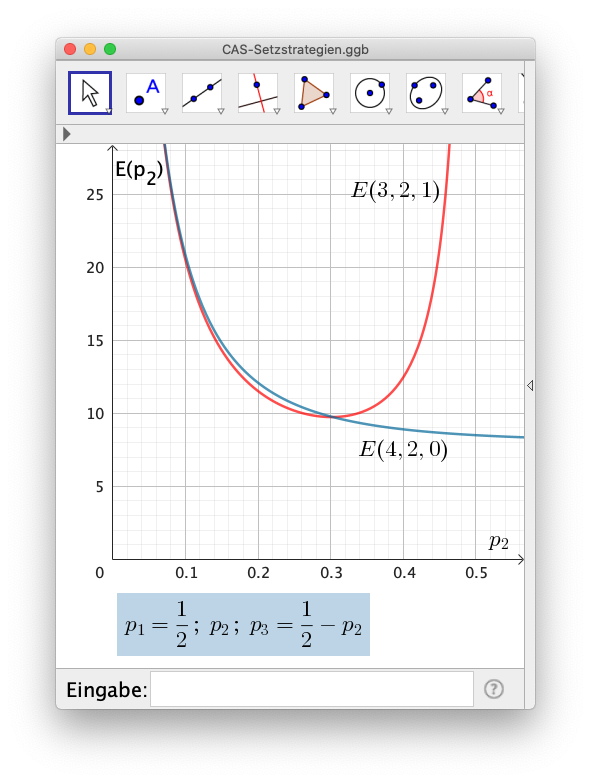

   - Untersuchen Sie, ob es einen Wert für $p_2$ gibt, so dass gilt: $ E(3,2,1)=E(4,2,0)$ 
   - Untersuchen Sie, ob es Werte für $p_2$ gibt, so dass gilt: $ E(3,2,1)<E(4,2,0)$ 

In [9]:
from sympy import symbols, simplify, factor
from fractions import Fraction

# Symbolische Variablen für p_1, p_2, p_3
p1, p2, p3 = symbols('p1 p2 p3')

# Eingabe (Setzstrategie)
S = [3, 2, 1]

# Wahrscheinlichkeiten als Liste
p = [Fraction(1,2),p2, Fraction(1/2)-p2]

# Anzahl der Elemente
n = len(S)

# Rekursive Berechnung des Erwartungswertes
def E(C, memo={}):
    if tuple(C) in memo: return memo[tuple(C)]

    if all(x == 0 for x in C): return 0  # Basisfall: keine Chips mehr
    
    # Wahrscheinlichkeiten für nicht-leere Gruppen
    d = [0] * n
    for i in range(n):
        if C[i] > 0: d[i] = p[i]

    # Summe der Wahrscheinlichkeiten s
    s = sum(d)

    # Erwartungswert
    EX = 1 / s
    for i in range(n):
        if C[i] > 0:
            C_new = C.copy()  # Neue Konfiguration
            C_new[i] -= 1
            EX += (d[i] / s) * E(C_new, memo)

    # Memoization store
    memo[tuple(C)] = EX
    return EX

# Berechnung des Erwartungswertes für S
EX = E(S)

# Ergebnis vereinfachen
EX_simplified = simplify(EX)
EX_factor = factor(EX)

# Ausgabe
print(f"Erwartungswert (symbolisch) : E({S}) = {EX}")
print()
print(f"Erwartungswert (vereinfacht): E({S}) = {EX_simplified}")
print()
print(f"Erwartungswert (vereinfacht): E({S}) = {EX_factor}")


Erwartungswert (symbolisch) : E([3, 2, 1]) = p2*(2*p2/(1/2 - p2) + 2 + (1 - 2*p2)/p2)/4 + p2*(p2*(2*(1/2 - p2)/(1 - p2) + 1/(1 - p2) + 1/(2*(1/2 - p2)*(1 - p2))) + p2/(1/2 - p2) + (1/2 - p2)*(2*p2/(p2 + 1/2) + 1/(p2 + 1/2) + 1/(2*p2*(p2 + 1/2))) + 2 + (1 - 2*p2)/(2*p2))/4 + p2*(p2*(2*(1/2 - p2)/(1 - p2) + 1/(1 - p2) + 1/(2*(1/2 - p2)*(1 - p2)))/2 + p2*(4*(1/2 - p2)/(1 - p2) + (2*(1/2 - p2)/(1 - p2) + 1/(1 - p2) + 1/(2*(1/2 - p2)*(1 - p2)))/(2*(1 - p2)) + 1/(1 - p2)) + p2/(2*(1/2 - p2)) + (1/2 - p2)*(2*p2/(p2 + 1/2) + 1/(p2 + 1/2) + 1/(2*p2*(p2 + 1/2)))/2 + (1/2 - p2)*(4*p2/(p2 + 1/2) + (2*p2/(p2 + 1/2) + 1/(p2 + 1/2) + 1/(2*p2*(p2 + 1/2)))/(2*(p2 + 1/2)) + 1/(p2 + 1/2)) + 2 + (1 - 2*p2)/(4*p2))/2 + p2*(p2*(2*(1/2 - p2)/(1 - p2) + 1/(1 - p2) + 1/(2*(1/2 - p2)*(1 - p2)))/4 + p2*(4*(1/2 - p2)/(1 - p2) + (2*(1/2 - p2)/(1 - p2) + 1/(1 - p2) + 1/(2*(1/2 - p2)*(1 - p2)))/(2*(1 - p2)) + 1/(1 - p2))/2 + p2*(6*(1/2 - p2)/(1 - p2) + (4*(1/2 - p2)/(1 - p2) + (2*(1/2 - p2)/(1 - p2) + 1/(1 - p2) + 1